In [1]:
import functions_model_analysis as f

import pandas as pd
import sys 
 
sys.path.insert(0, '../AWS_Scripts')
from functions_training_pipeline import Model

In [6]:
LinReg_noLog = f.load_object('LinearRegression_WithoutLog')
LinReg = f.load_object('LinearRegression')

RigdeReg = f.load_object('RidgeRegression')
RidgeReg_noLog = f.load_object('RidgeRegression_WithoutLog')

LassoReg = f.load_object('LassoRegression')
ElasticNetReg = f.load_object('ElasticNetRegression')

LinearRegression


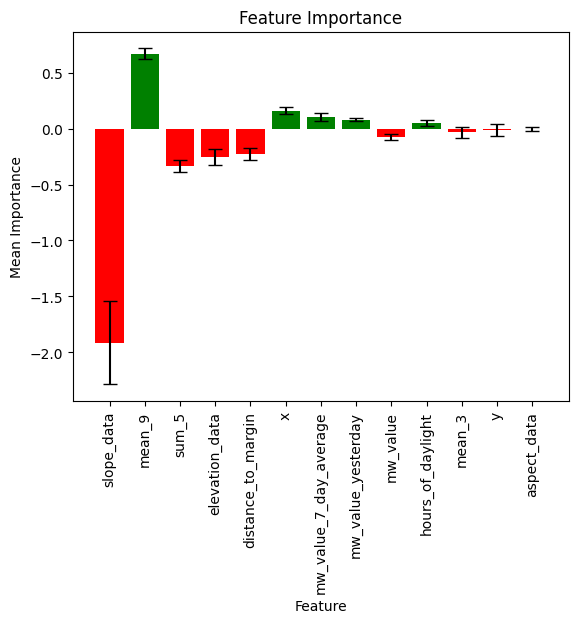

LinearRegression


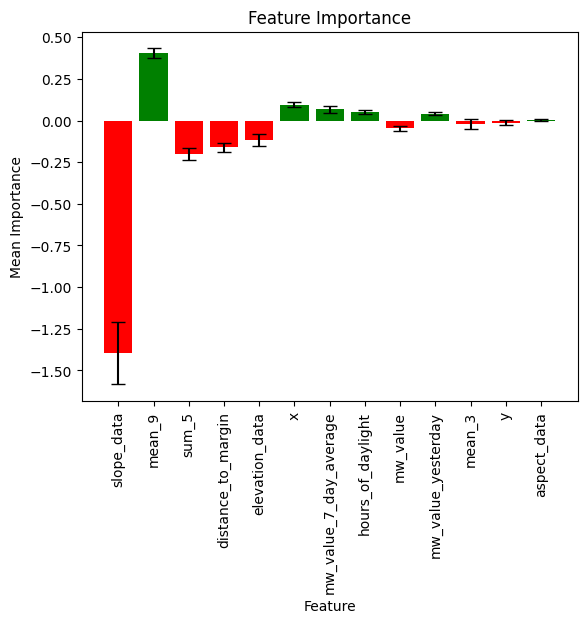

RidgeRegression


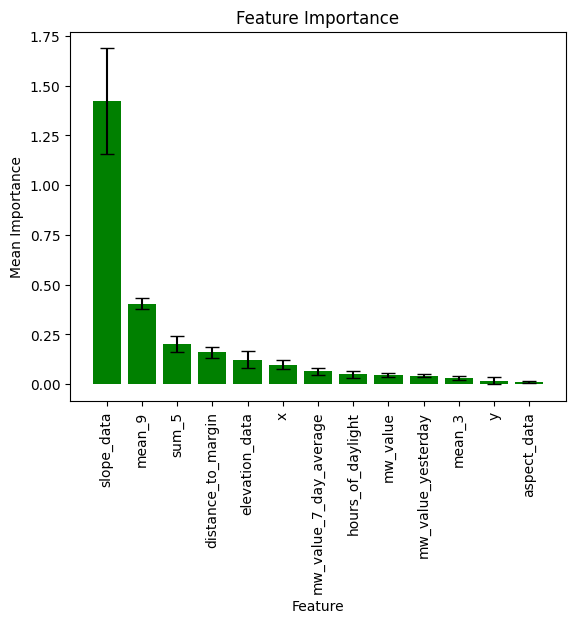

RidgeRegression_WithoutLog


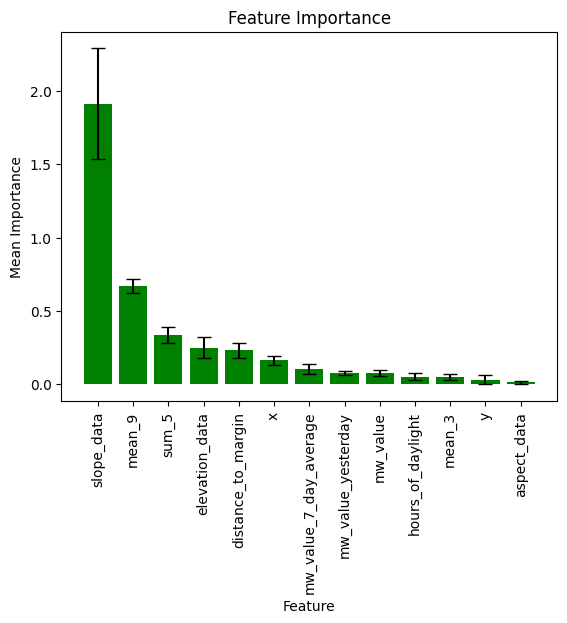

LassoRegression


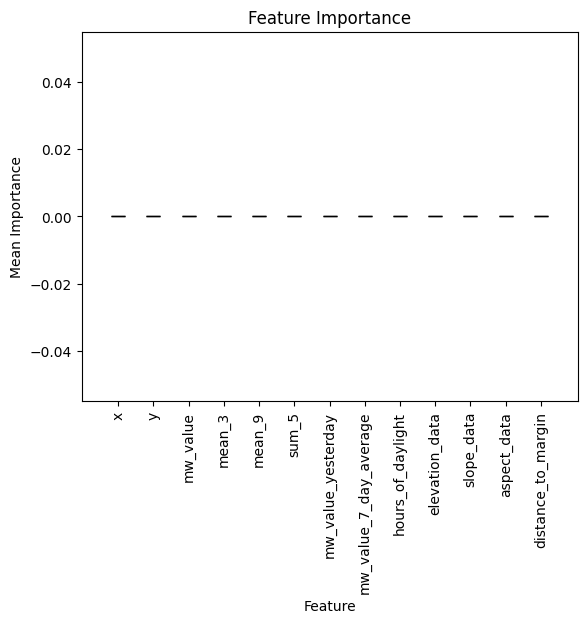

ElasticNetRegression


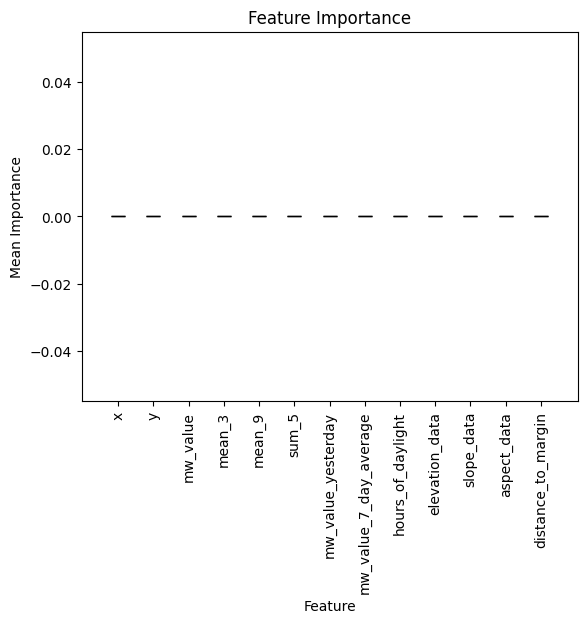

In [8]:
for model in [LinReg_noLog, LinReg, RigdeReg, RidgeReg_noLog, LassoReg, ElasticNetReg]:
    print(model.name)
    f.plot_feature_importance(model)